<a href="https://colab.research.google.com/github/michalinajnk/Deep-Fake-Detection-in-Face-Images/blob/main/Deep_Learning_Project_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!pip install fastbook --quiet
!pip install matplotlib
!pip install opencv-python

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from pathlib import Path
root = '/content/drive/MyDrive/project' # Don't change this
data_dirname = '/real_and_fake_face_300x300'
p = Path(root + data_dirname)
p.mkdir(exist_ok=True)

Install Python packages in the environment

Give the path of the dataset and create the folder if it doesn't exist.

In [ ]:
!ls -l "/content/gdrive/MyDrive/project/real_and_fake_face_300x300_without_hard"

ls: cannot access '/content/gdrive/MyDrive/project/real_and_fake_face_300x300_without_hard': No such file or directory


Create the labels.

In [ ]:
classes = ['fake','real']
num_classes = len(classes)

Print the path of each file in the directory.

Use VGG model.

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base_VGG = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='max',
    classes=2,
    classifier_activation="softmax",
)

58889256/58889256 [==============================] - 0s 0us/step


Use Xception model.

In [ ]:
# Xception
from tensorflow.keras.applications import Xception

conv_base_Xception = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(300, 300, 3),
                          pooling='max',
                          classes=2)


83683744/83683744 [==============================] - 5s 0us/step


Use ResNet50 model.

In [ ]:
# ResNet50
from tensorflow.keras.applications import ResNet50V2

conv_base_ResNet = ResNet50V2(include_top=False,
                        weights="imagenet",
                        input_shape=(300, 300, 3),
                        pooling='max',
                        classes=2,
                        )
                        # classifier_activation="softmax")

94668760/94668760 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Model

mode = 'resnet'
conv_base = None

if mode == 'resnet':
  from tensorflow.keras.applications.resnet_v2 import preprocess_input
  conv_base = conv_base_ResNet
elif mode == 'xception':
  from tensorflow.keras.applications.xception import preprocess_input
  conv_base = conv_base_Xception
elif mode == 'vgg':
  from tensorflow.keras.applications.vgg16 import preprocess_input
  conv_base = conv_base_VGG

for layer in conv_base.layers:
          layer.trainable=False

x = Flatten()(conv_base.output)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=conv_base.input, outputs=output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model with the Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=10**-5),  # You can adjust the learning rate
    loss='categorical_crossentropy',  # Use the appropriate loss function for your task
    metrics=['accuracy']  # Use relevant metrics for evaluation
)


In [ ]:
# Image loading and preprocessing
# ImageDataGenerator is depricated, we need to use: image_dataset_from_directory
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (300, 300)
batch_size = 32
class_names = ['fake', 'real']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_directory = '/content/drive/MyDrive/project/real_and_fake_face_300x300_without_hard/train'
validation_data_directory = '/content/drive/MyDrive/project/real_and_fake_face_300x300_without_hard/validation'
test_data_directory = '/content/drive/MyDrive/project/real_and_fake_face_300x300_without_hard/test'

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

train_dataset = datagen.flow_from_directory(
    train_data_directory,
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',  # Choose the appropriate class mode
    shuffle=True  # Set this based on your requirements
)

validation_dataset = datagen.flow_from_directory(
    validation_data_directory,
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
  class_mode='categorical'
)

test_dataset = datagen.flow_from_directory(
    test_data_directory,
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',  # Choose the appropriate class mode
)


Found 1267 images belonging to 2 classes.
Found 265 images belonging to 2 classes.
Found 269 images belonging to 2 classes.


In [ ]:
# train_data_directory = '/content/gdrive/My Drive/project/real_and_fake_face_300x300/train'
# validation_data_directory = '/content/gdrive/My Drive/project/real_and_fake_face_300x300/validation'
# test_data_directory = '/content/gdrive/My Drive/project/real_and_fake_face_300x300/test'

# # Training dataset
# train_dataset = image_dataset_from_directory(
#     train_data_directory,
#     labels='inferred',
#     label_mode='categorical',
#     class_names=class_names,
#     image_size=image_size,
#     batch_size=batch_size,
#     shuffle=True,
#     seed=43,
#     # preprocessing=preprocess_input
# )

# # Validation dataset
# validation_dataset = image_dataset_from_directory(
#     validation_data_directory,
#     labels='inferred',
#     label_mode='categorical',
#     class_names=class_names,
#     image_size=image_size,
#     batch_size=batch_size,
#     shuffle=False,  # Don't shuffle for validation data
#     seed=49,
#     # preprocessing=preprocess_input
# )

# # Test dataset
# test_dataset = image_dataset_from_directory(
#     test_data_directory,
#     labels='inferred',
#     label_mode='categorical',
#     class_names=class_names,
#     image_size=image_size,
#     batch_size=batch_size,
#     shuffle=False,  # Don't shuffle for test data
#     seed=42,
#     # preprocessing=preprocess_input
# )

In [ ]:
# # Preprocessing
# def preprocess_images(image, label):
#     image = preprocess_input(image)
#     return image, label

# # Apply data augmentation to the training dataset
# # train_dataset = train_dataset.map(lambda x, y: (datagen.random_transform(x), y))

# # Apply preprocessing to the datasets
# train_dataset = train_dataset.map(preprocess_images)

# validation_dataset = validation_dataset.map(preprocess_images)
# test_dataset = test_dataset.map(preprocess_images)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model_snapshots_dir = '/content/drive/MyDrive/project/model_checkpoints'

# Use ModelCheckpoint to save the best model snapshot based on validation accuracy
checkpoint_filepath = os.path.join(model_snapshots_dir, 'best_model_resnet.h5')
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
# Training
history = model.fit(
    train_dataset,
    epochs=30,
    verbose=1,
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 1.8457 - accuracy: 0.5114

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 476s 12s/step - loss: 1.8457 - accuracy: 0.5114 - val_loss: 1.3371 - val_accuracy: 0.5585
Epoch 2/30
40/40 [==============================] - 41s 1s/step - loss: 1.3700 - accuracy: 0.5651 - val_loss: 1.2369 - val_accuracy: 0.5660
Epoch 3/30
40/40 [==============================] - 40s 993ms/step - loss: 1.2384 - accuracy: 0.5872 - val_loss: 1.3871 - val_accuracy: 0.5132
Epoch 4/30
40/40 [==============================] - 40s 1s/step - loss: 1.0421 - accuracy: 0.5951 - val_loss: 1.1654 - val_accuracy: 0.5811
Epoch 5/30
40/40 [==============================] - 41s 1s/step - loss: 1.0047 - accuracy: 0.6054 - val_loss: 1.1991 - val_accuracy: 0.5623
Epoch 6/30
40/40 [==============================] - 39s 991ms/step - loss: 0.8653 - accuracy: 0.6480 - val_loss: 1.1043 - val_accuracy: 0.5887
Epoch 7/30
40/40 [==============================] - 41s 1s/step - loss: 0.8131 - accuracy: 0.6496 - val_loss: 1.1460 - val_accuracy: 0.5623
Epoch 8/30
40/40 [=====

In [ ]:
from tensorflow import keras

model.save("/content/drive/MyDrive/project/resnet_model_best.keras")

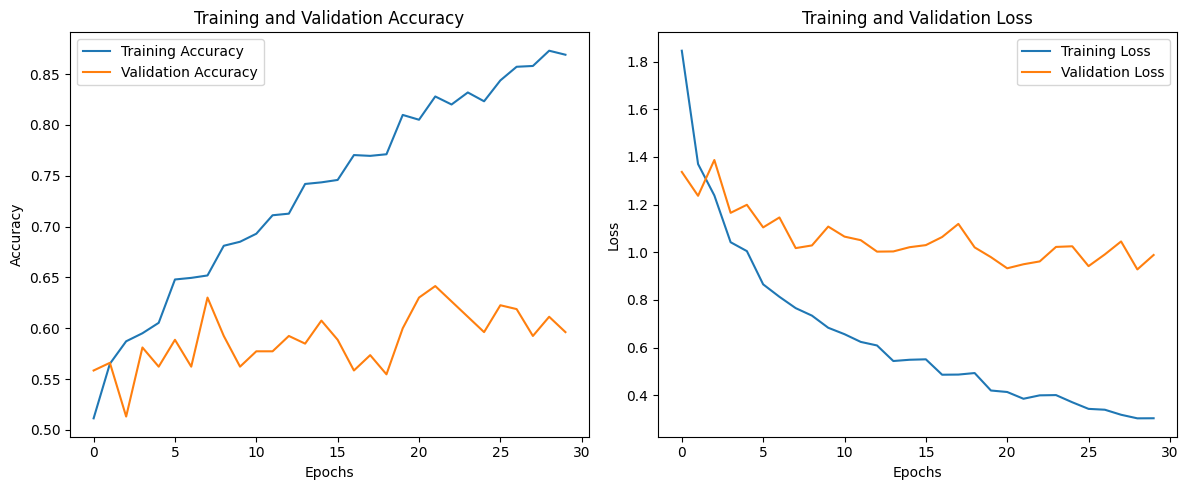

In [ ]:
import matplotlib.pyplot as plt

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

9/9 [==============================] - 107s 13s/step - loss: 1.0476 - accuracy: 0.6022
Test Loss: 1.0476
Test Accuracy: 0.6022
9/9 [==============================] - 7s 642ms/step


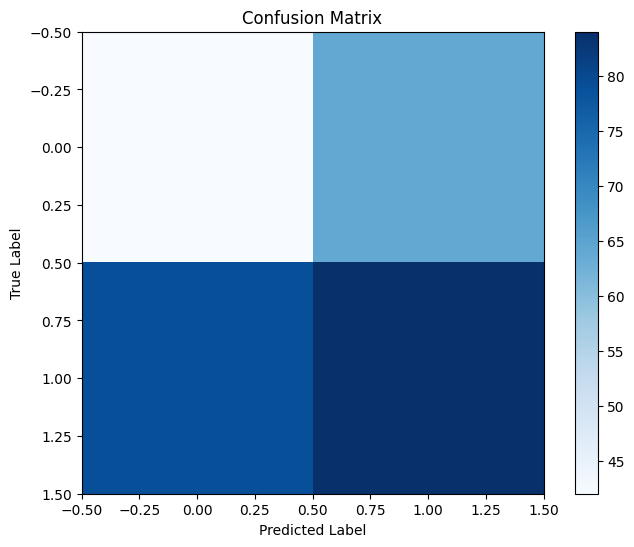

Classification Report:
               precision    recall  f1-score   support

        fake       0.35      0.40      0.37       106
        real       0.57      0.52      0.54       163

    accuracy                           0.47       269
   macro avg       0.46      0.46      0.46       269
weighted avg       0.48      0.47      0.47       269



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

loss, accuracy = model.evaluate(test_dataset, verbose=1)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_dataset.classes

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=test_dataset.class_indices.keys())
print('Classification Report:\n', class_report)


In [ ]:
# Save the trained model, or if you want to use a different model, just load it with the next code section
from datetime import datetime
from keras.models import save_model

current_time = datetime.today().strftime('%Y-%m-%d_%H:%M:%S')

# Saving model in Keras format
model.save(f"/content/gdrive/MyDrive/project/{current_time}resnet_best_noHard_e={epoch}_b={batch_size}.keras")


In [ ]:
# Load the already saved model from the project directory
from keras.models import load_model

model = load_model(root + "/resnet_best_noHard_e=20_b=32_lr=-5.keras")

1/1 [==============================] - 0s 26ms/step


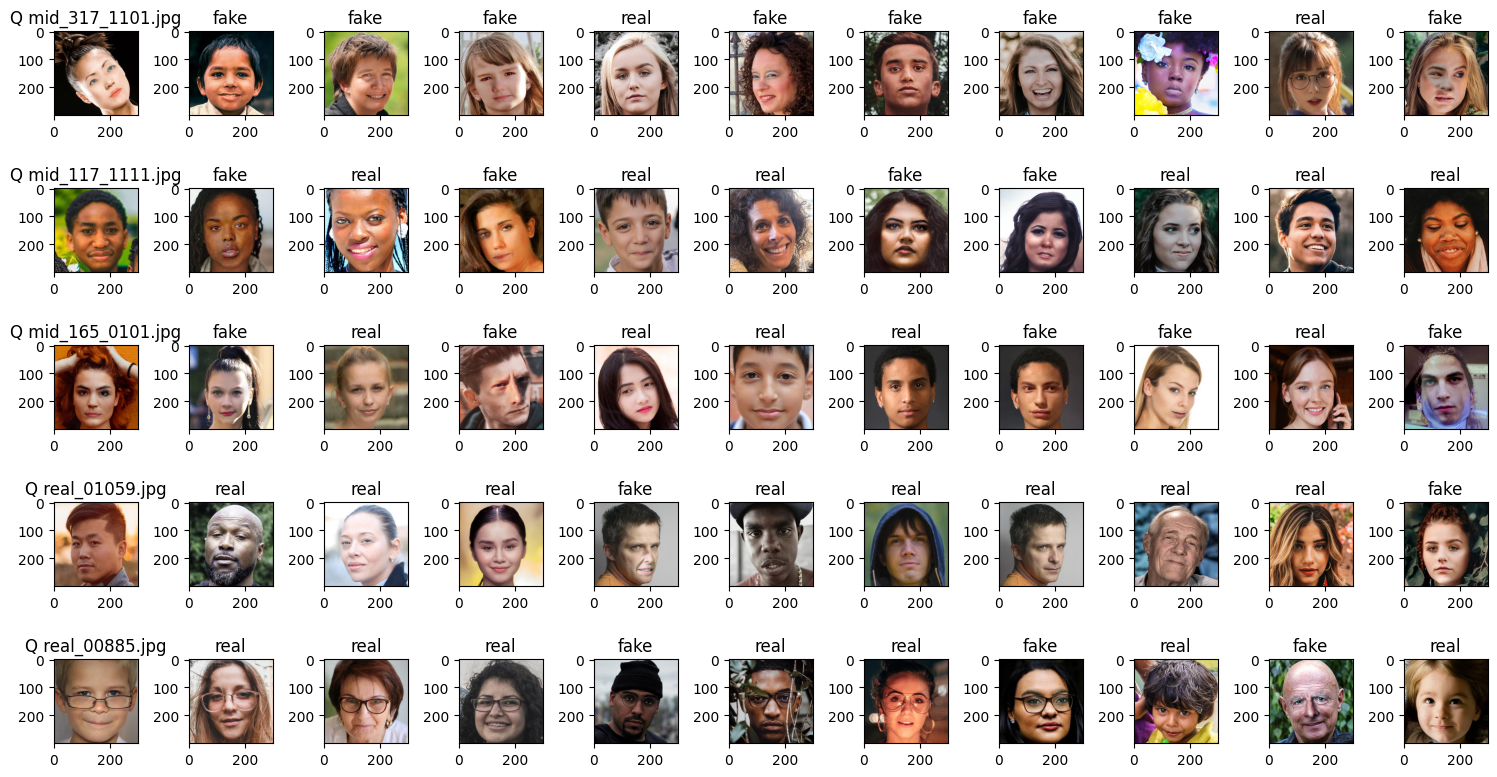

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

def visualize_layer(query_image_paths, layer_name, model, train_data_directory, output_directory, k=10):

    # Specify the layer whose feature vectors you want to use for comparison
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # List of image paths for queries
    query_labels = []
    query_feature_vectors = []

    # Load and preprocess each query image
    for query_path in query_image_paths:
        img = image.load_img(query_path, target_size=(300, 300))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Get the feature vector from the specified dense layer
        feature_vector = intermediate_layer_model.predict(img_array)
        query_feature_vectors.append(feature_vector.flatten())
        query_labels.append(os.path.basename(query_path))

    query_feature_vectors = np.array(query_feature_vectors)
    query_labels = np.array(query_labels)

    # Load and preprocess training images for comparison
    train_labels = []
    train_feature_vectors = []

    classes = os.listdir(train_data_directory)
    for class_folder in classes:
        class_path = os.path.join(train_data_directory, class_folder)
        image_files = os.listdir(class_path)
        for image_file in image_files:
            img_path = os.path.join(class_path, image_file)
            img = image.load_img(img_path, target_size=(300, 300))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Get the feature vector from the specified dense layer
            feature_vector = intermediate_layer_model.predict(img_array)
            train_feature_vectors.append(feature_vector.flatten())
            train_labels.append((class_folder, image_file))  # Tuple containing class folder and filename

    train_labels = np.array(train_labels)
    train_feature_vectors = np.array(train_feature_vectors)

    # Use Nearest Neighbors to find the k most similar images for each query
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(train_feature_vectors)

    # Plot the images and their k nearest neighbors horizontally
    plt.figure(figsize=(15, 8))

    for i in range(len(query_image_paths)):
        plt.subplot(len(query_image_paths), k + 1, i * (k + 1) + 1)
        plt.imshow(plt.imread(query_image_paths[i]))
        plt.title(f'Q {os.path.basename(query_image_paths[i])}')

        distances, indices = knn.kneighbors([query_feature_vectors[i]])

        for j in range(k):
            class_folder, neighbor_filename = train_labels[indices.flatten()[j]]
            neighbor_img_path = os.path.join(train_data_directory, class_folder, neighbor_filename)
            neighbor_img = plt.imread(neighbor_img_path)
            plt.subplot(len(query_image_paths), k + 1, i * (k + 1) + j + 2)
            plt.imshow(neighbor_img)
            plt.title(f'{class_folder}')  # Display the class name instead of "Neighbor {j + 1}"

            # Save the visualizations with preserved filenames
            output_filename = f'query_{os.path.basename(query_image_paths[i])}_neighbor_{os.path.basename(neighbor_img_path)}_{j + 1}.jpg'
            plt.imsave(os.path.join(output_directory, output_filename), neighbor_img)

    plt.tight_layout()
    plt.show()

# Example usage:
image_directory = '/content/gdrive/MyDrive/project/real_and_fake_face_300x300_without_hard/test/'
image_paths = ['fake/mid_317_1101.jpg', 'fake/mid_117_1111.jpg', 'fake/mid_165_0101.jpg', 'real/real_01059.jpg', 'real/real_00885.jpg']
query_image_paths = [os.path.join(image_directory, name) for name in image_paths]

layer_name_to_visualize = 'dense'  # Replace with the name of your dense layer
train_data_directory_to_load = '/content/gdrive/MyDrive/project/real_and_fake_face_300x300_without_hard/train'
output_directory_to_save = '/content/gdrive/MyDrive/project/visualization_output'

# visualize_layer(query_image_paths, 'dense, model, train_data_directory_to_load, output_directory_to_save)
visualize_layer(query_image_paths, 'dense_1', model, train_data_directory_to_load, output_directory_to_save, k=10)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_xception
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout

train_data_directory = '/content/drive/MyDrive/project/real_and_fake_face_300x300_without_hard/train'
validation_data_directory = '/content/drive/MyDrive/project/real_and_fake_face_300x300_without_hard/validation'
test_data_directory = '/content/drive/MyDrive/project/real_and_fake_face_300x300_without_hard/test'


# Define the models and batch sizes
models = {'vgg': conv_base_VGG, 'xception': conv_base_Xception, 'resnet': conv_base_ResNet}
dropout_rates = [0.2, 0.3, 0.4]

# Define some parameters
batch_size = 32
num_classes = 2
image_size = (300, 300)
epochs = 10
base_dir = '/content/drive/MyDrive/project/'

# Create a directory to save the results
result_dir = os.path.join(base_dir, 'results')
os.makedirs(result_dir, exist_ok=True)

# Loop over models
for model_name, conv_base in models.items():

    for layer in conv_base.layers:
       layer.trainable=False

    if model_name == 'resnet':
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input_resnet_v2,
            rotation_range=5,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode='nearest'
        )
    elif model_name == 'xception':
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input_xception,
            rotation_range=5,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode='nearest'
        )
    elif model_name == 'vgg':
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input_vgg,
            rotation_range=5,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode='nearest'
        )

    train_dataset = datagen.flow_from_directory(
            train_data_directory,
            target_size=image_size,
            color_mode="rgb",
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
        )

    validation_dataset = datagen.flow_from_directory(
        validation_data_directory,
        target_size=image_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_dataset = datagen.flow_from_directory(
        test_data_directory,
        target_size=image_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical'
    )


    # Loop over batch sizes
    for dropout_rate in dropout_rates:

        # Decoder
        x = Flatten()(conv_base.output)
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)  # Add BatchNormalization
        x = Dropout(dropout_rate)(x)  # Add Dropout

        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)  # Add BatchNormalization
        x = Dropout(dropout_rate)(x)  # Add Dropout

        output = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs=conv_base.input, outputs=output)

        # Compile the model with the Adam optimizer
        model.compile(
            optimizer=Adam(learning_rate=10**-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Create a directory to save model snapshots
        model_snapshots_dir = os.path.join(result_dir, f'{model_name}_dropout_rate_{dropout_rate}_snapshots')
        os.makedirs(model_snapshots_dir, exist_ok=True)

        # Use ModelCheckpoint to save the best model snapshot based on validation accuracy
        checkpoint_filepath = os.path.join(model_snapshots_dir, 'best_model.h5')
        model_checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )

        # Define EarlyStopping callback
        early_stopping_callback = EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            patience=5,  # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
        )

        # Create a directory to save evaluation plots
        plots_dir = os.path.join(model_snapshots_dir, 'evaluation_plots')
        os.makedirs(plots_dir, exist_ok=True)

        # Training
        history = model.fit(
            train_dataset,
            epochs=epochs,
            verbose=1,
            validation_data=validation_dataset,
            callbacks=[early_stopping_callback, model_checkpoint_callback]
        )

        # Save the training history to a file
        history_filepath = os.path.join(model_snapshots_dir, 'training_history.npy')
        np.save(history_filepath, history.history)

        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Save other relevant information
        info_filepath = os.path.join(model_snapshots_dir, 'info.txt')
        with open(info_filepath, 'w') as f:
            f.write(f'Model: {model_name}\n')
            f.write(f'Dropout rate: {dropout_rate}\n')
            f.write(f'Accuracy train: {training_accuracy}\n')
            f.write(f'Accuracy validation: {validation_accuracy}\n')
            f.write(f'Train loss: {training_loss}\n')
            f.write(f'Validation loss: {validation_loss}\n')

        # Save evaluation plots in the 'evaluation_plots' directory
        plot_filepath = os.path.join(plots_dir, 'evaluation_plots.png')

        # Plot the training and validation accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(training_accuracy, label='Training Accuracy')
        plt.plot(validation_accuracy, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Plot the training and validation loss
        plt.subplot(1, 2, 2)
        plt.plot(training_loss, label='Training Loss')
        plt.plot(validation_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(plot_filepath)
        plt.close()  # Close the plot to avoid displaying in the console

        # Evaluate the model on the test set
        loss, accuracy = model.evaluate(test_dataset, verbose=1)
        print(f'Test Loss: {loss:.4f}')
        print(f'Test Accuracy: {accuracy:.4f}')

        # Generate predictions
        y_pred = model.predict(test_dataset)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = test_dataset.classes

        # Print classification report
        class_report = classification_report(y_true_classes, y_pred_classes, target_names=test_dataset.class_indices.keys())
        print('Classification Report:\n', class_report)
        class_report_filepath = os.path.join(model_snapshots_dir, 'classification_report.txt')
        with open(class_report_filepath, 'w') as f:
            f.write('Classification Report:\n')
            f.write(class_report)



Found 1267 images belonging to 2 classes.
Found 265 images belonging to 2 classes.
Found 269 images belonging to 2 classes.
Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.1917 - accuracy: 0.5028 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 764s 19s/step - loss: 1.1917 - accuracy: 0.5028 - val_loss: 4.6515 - val_accuracy: 0.3887
Epoch 2/10
40/40 [==============================] - 44s 1s/step - loss: 1.1179 - accuracy: 0.5201 - val_loss: 2.1316 - val_accuracy: 0.4075
Epoch 3/10
40/40 [==============================] - 42s 1s/step - loss: 1.0470 - accuracy: 0.5233 - val_loss: 1.4936 - val_accuracy: 0.4604
Epoch 4/10
40/40 [==============================] - 49s 1s/step - loss: 0.9883 - accuracy: 0.5478 - val_loss: 1.1222 - val_accuracy: 0.4868
Epoch 5/10
40/40 [==============================] - 47s 1s/step - loss: 1.0004 - accuracy: 0.5493 - val_loss: 1.0570 - val_accuracy: 0.4943
Epoch 6/10
40/40 [==============================] - 46s 1s/step - loss: 0.9546 - accuracy: 0.5738 - val_loss: 0.9594 - val_accuracy: 0.5698
Epoch 7/10
40/40 [==============================] - 43s 1s/step - loss: 0.9588 - accuracy: 0.5580 - val_loss: 0.9205 - val_accuracy: 0.5585
Epoch 8/10
40/40 [===========

NameError: ignored